# Soccer Match Outcome Predictor

The following code will build a soccer match outcome prediction model using nural networks with team embeddings and match history embeddings.

Installing Necessary Packages

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Dense, Concatenate, Dropout, Flatten, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from keras import layers, models, optimizers, callbacks
import keras_tuner as kt

## Preprocessing the Dataset

Loading the Dataset

In [3]:
df = pd.read_csv('matches_expanded.csv')
df.head(10)

,match_id,home_team,away_team,home_goals,away_goals,match_outcome,Home_Ball_Possession,Home_Pass_Accuracy,Home_Total_Shots,Home_Expected_Goals,Away_Ball_Possession,Away_Pass_Accuracy,Away_Total_Shots,Away_Expected_Goals
0,1035037,Burnley,Manchester City,0,3,Loss,34%,79%,6,0.33,66%,90%,17,2.08
1,1035038,Arsenal,Nottingham Forest,2,1,Win,78%,90%,15,0.83,22%,69%,6,1.18
2,1035039,Bournemouth,West Ham,1,1,Draw,63%,82%,14,1.37,37%,68%,16,1.07
3,1035041,Everton,Fulham,0,1,Loss,41%,79%,19,2.73,59%,85%,9,1.50
4,1035040,Brighton,Luton,4,1,Win,71%,91%,27,4.01,29%,72%,9,1.48
5,1035042,Sheffield Utd,Crystal Palace,0,1,Loss,32%,62%,8,0.51,68%,83%,24,1.89
6,1035043,Newcastle,Aston Villa,5,1,Win,53%,85%,17,3.41,47%,85%,16,1.77
7,1035044,Brentford,Tottenham,2,2,Draw,30%,77%,11,2.22,70%,90%,18,1.27
8,1035045,Chelsea,Liverpool,1,1,Draw,65%,87%,10,1.35,35%,80%,13,1.28
9,1035046,Manchester United,Wolves,1,0,Win,51%,82%,15,2.21,49%,81%,23,2.35


Cleaning the Dataset

In [4]:
df.columns = df.columns.str.lower()

df['home_ball_possession'] = df['home_ball_possession'].str.replace('%', '', regex=True).astype(float)
df['home_pass_accuracy'] = df['home_pass_accuracy'].str.replace('%', '', regex=True).astype(float)
df['away_ball_possession'] = df['away_ball_possession'].str.replace('%', '', regex=True).astype(float)
df['away_pass_accuracy'] = df['away_pass_accuracy'].str.replace('%', '', regex=True).astype(float)

# Feature Engineering

Adding New Statistics

In [5]:
df["home_expected_goals_against"] = df["away_expected_goals"]
df["away_expected_goals_against"] = df["home_expected_goals"]

df["home_conversion_rate"] = df["home_goals"] / df["home_total_shots"]
df["away_conversion_rate"] = df["away_goals"] / df["away_total_shots"]

df["home_goal_difference"] = df["home_goals"] - df["away_goals"]
df["away_goal_difference"] = df["away_goals"] - df["home_goals"]

df["home_expected_goals_difference"] = df["home_expected_goals"] - df["away_expected_goals"]
df["away_expected_goals_difference"] = df["away_expected_goals"] - df["home_expected_goals"]

df["home_expected_goals_against_difference"] = df["home_expected_goals_against"] - df["away_expected_goals_against"]
df["away_expected_goals_against_difference"] = df["away_expected_goals_against"] - df["home_expected_goals_against"]

df["home_shot_difference"] = df["home_total_shots"] - df["away_total_shots"]
df["away_shot_difference"] = df["away_total_shots"] - df["home_total_shots"]


Capturing the Statistics of a Team Over 5 Matches

In [6]:
# Function to compute rolling averages for all rows in the DataFrame
def add_rolling_avg_stat(df, stat_col_prefix, num_matches=5):
    home_avgs = []
    away_avgs = []

    for i in range(len(df)):
        current_row = df.iloc[i]
        home_team = current_row["home_team"]
        away_team = current_row["away_team"]
        prior_matches = df.iloc[:i]

        # Get home team history
        home_matches = prior_matches[
            (prior_matches["home_team"] == home_team) | (prior_matches["away_team"] == home_team)
        ].tail(num_matches)

        home_values = []
        for _, m in home_matches.iterrows():
            if m["home_team"] == home_team:
                home_values.append(m[f"home_{stat_col_prefix}"])
            else:
                home_values.append(m[f"away_{stat_col_prefix}"])
        home_avg = np.mean(home_values) if home_values else np.nan
        if np.isnan(home_avg):
            home_avg = current_row[f"home_{stat_col_prefix}"]
        home_avgs.append(home_avg)

        # Get away team history
        away_matches = prior_matches[
            (prior_matches["home_team"] == away_team) | (prior_matches["away_team"] == away_team)
        ].tail(num_matches)

        away_values = []
        for _, m in away_matches.iterrows():
            if m["home_team"] == away_team:
                away_values.append(m[f"home_{stat_col_prefix}"])
            else:
                away_values.append(m[f"away_{stat_col_prefix}"])
        away_avg = np.mean(away_values) if away_values else np.nan
        if np.isnan(away_avg):
            away_avg = current_row[f"away_{stat_col_prefix}"]
        away_avgs.append(away_avg)

    # Store in DataFrame
    df[f"home_{stat_col_prefix}_last{num_matches}_avg"] = home_avgs
    df[f"away_{stat_col_prefix}_last{num_matches}_avg"] = away_avgs

    return df

# Apply function to statistics
stats_to_process = ["goals", "ball_possession", "pass_accuracy", "total_shots", "expected_goals", "expected_goals_against", "conversion_rate", "goal_difference", "expected_goals_difference", "expected_goals_against_difference", "shot_difference"]

for stat in stats_to_process:
    df = add_rolling_avg_stat(df, stat, num_matches=5)


In [ ]:
df['home_under_1_5_goals_last5'] = df['home_goals_last5_avg'] < 1.5
df['away_under_1_5_goals_last5'] = df['away_goals_last5_avg'] < 1.5

Capturing the Statistics of a Team Over The Season

In [7]:
def add_avg_stat_all_history(df, stat_col_prefix):
    home_avgs = []
    away_avgs = []

    for i in range(len(df)):
        current_row = df.iloc[i]
        home_team = current_row["home_team"]
        away_team = current_row["away_team"]
        prior_matches = df.iloc[:i]

        # Home team average (all matches before i)
        home_values = []
        for _, match in prior_matches.iterrows():
            if match["home_team"] == home_team:
                home_values.append(match[f"home_{stat_col_prefix}"])
            elif match["away_team"] == home_team:
                home_values.append(match[f"away_{stat_col_prefix}"])
        home_avg = np.mean(home_values) if home_values else np.nan
        if np.isnan(home_avg):
            home_avg = current_row[f"home_{stat_col_prefix}"]
        home_avgs.append(home_avg)

        # Away team average (all matches before i)
        away_values = []
        for _, match in prior_matches.iterrows():
            if match["home_team"] == away_team:
                away_values.append(match[f"home_{stat_col_prefix}"])
            elif match["away_team"] == away_team:
                away_values.append(match[f"away_{stat_col_prefix}"])
        away_avg = np.mean(away_values) if away_values else np.nan
        if np.isnan(away_avg):
            away_avg = current_row[f"away_{stat_col_prefix}"]
        away_avgs.append(away_avg)

    df[f"home_{stat_col_prefix}_avg_all"] = home_avgs
    df[f"away_{stat_col_prefix}_avg_all"] = away_avgs

    return df

stats_to_process = ["goals", "ball_possession", "pass_accuracy", "total_shots", "expected_goals", "expected_goals_against", "conversion_rate", "goal_difference", "expected_goals_difference", "expected_goals_against_difference", "shot_difference"]

for stat in stats_to_process:
    df = add_avg_stat_all_history(df, stat)

Capturing League Form (how many wins, draws, losses in 5 games)

In [8]:
def add_last5_results(df, num_matches=5):
    home_wins, home_draws, home_losses = [], [], []
    away_wins, away_draws, away_losses = [], [], []

    for i in range(len(df)):
        current_row = df.iloc[i]
        home_team = current_row["home_team"]
        away_team = current_row["away_team"]
        prior_matches = df.iloc[:i]

        def get_team_result(row, team):
            if row["home_team"] == team:
                if row["home_goals"] > row["away_goals"]:
                    return "win"
                elif row["home_goals"] < row["away_goals"]:
                    return "loss"
                else:
                    return "draw"
            elif row["away_team"] == team:
                if row["away_goals"] > row["home_goals"]:
                    return "win"
                elif row["away_goals"] < row["home_goals"]:
                    return "loss"
                else:
                    return "draw"
            else:
                return None

        home_matches = prior_matches[
            (prior_matches["home_team"] == home_team) | (prior_matches["away_team"] == home_team)
        ].tail(num_matches)
        home_results = [get_team_result(m, home_team) for _, m in home_matches.iterrows()]
        home_wins.append(home_results.count("win"))
        home_draws.append(home_results.count("draw"))
        home_losses.append(home_results.count("loss"))

        away_matches = prior_matches[
            (prior_matches["home_team"] == away_team) | (prior_matches["away_team"] == away_team)
        ].tail(num_matches)
        away_results = [get_team_result(m, away_team) for _, m in away_matches.iterrows()]
        away_wins.append(away_results.count("win"))
        away_draws.append(away_results.count("draw"))
        away_losses.append(away_results.count("loss"))

    df["home_wins_last5"] = home_wins
    df["home_draws_last5"] = home_draws
    df["home_losses_last5"] = home_losses
    df["away_wins_last5"] = away_wins
    df["away_draws_last5"] = away_draws
    df["away_losses_last5"] = away_losses

    return df

df = add_last5_results(df, num_matches=5)

Capturing Season Long Results (how many wins, draws, losses across the entire season)

In [9]:
def add_result_history(df):
    home_wins, home_draws, home_losses = [], [], []
    away_wins, away_draws, away_losses = [], [], []

    for i in range(len(df)):
        row = df.iloc[i]
        home_team = row["home_team"]
        away_team = row["away_team"]
        prior = df.iloc[:i]

        def result(row, team):
            if row["home_team"] == team:
                return "win" if row["home_goals"] > row["away_goals"] else "loss" if row["home_goals"] < row["away_goals"] else "draw"
            if row["away_team"] == team:
                return "win" if row["away_goals"] > row["home_goals"] else "loss" if row["away_goals"] < row["home_goals"] else "draw"

        home_results = [result(m, home_team) for _, m in prior[(prior["home_team"] == home_team) | (prior["away_team"] == home_team)].iterrows()]
        away_results = [result(m, away_team) for _, m in prior[(prior["home_team"] == away_team) | (prior["away_team"] == away_team)].iterrows()]

        home_wins.append(home_results.count("win"))
        home_draws.append(home_results.count("draw"))
        home_losses.append(home_results.count("loss"))
        away_wins.append(away_results.count("win"))
        away_draws.append(away_results.count("draw"))
        away_losses.append(away_results.count("loss"))

    df["home_wins_all"] = home_wins
    df["home_draws_all"] = home_draws
    df["home_losses_all"] = home_losses
    df["away_wins_all"] = away_wins
    df["away_draws_all"] = away_draws
    df["away_losses_all"] = away_losses

    return df

df = add_result_history(df)

In [10]:
df.to_csv('features.csv', index=False)

## Building the Neural Network Model

Label Ecode Team Names

In [10]:
team_encoder = LabelEncoder()
df['home_team_id'] = team_encoder.fit_transform(df['home_team'])
df['away_team_id'] = team_encoder.transform(df['away_team'])

Implementing Standard Scaling

In [11]:
numerical_cols = [col for col in df.columns if col.endswith('_last5_avg') or col.endswith('_avg_all') or col.endswith('_last5') or col.endswith('_all')]
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

Gathering Inputs

In [12]:
X = df[numerical_cols]
X = X.copy()
X['home_team_id'] = df['home_team_id'].values
X['away_team_id'] = df['away_team_id'].values


Label Encode Target (Win/Draw/Loss)

In [13]:
outcome_encoder = LabelEncoder()
df['outcome_encoded'] = outcome_encoder.fit_transform(df['match_outcome'])
y = to_categorical(df['outcome_encoded'], num_classes=3)

Spliting Data Into Training and Test Datasets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Building the Model

In [15]:
input_layer = Input(shape=(X_train.shape[1],))
x = Dense(128, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(3, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [16]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.2619 - loss: 1.7746 - val_accuracy: 0.2581 - val_loss: 1.4379
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4841 - loss: 1.1692 - val_accuracy: 0.3871 - val_loss: 1.2850
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4749 - loss: 1.1034 - val_accuracy: 0.4516 - val_loss: 1.1104
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5257 - loss: 1.0876 - val_accuracy: 0.4516 - val_loss: 1.0707
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5164 - loss: 1.0189 - val_accuracy: 0.3871 - val_loss: 1.0914
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5504 - loss: 0.9784 - val_accuracy: 0.3871 - val_loss: 1.0908
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5296 - loss: 1.0048 - val_accuracy: 0.4194 - val_loss: 1.0463
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5542 - loss: 0.9620 - val_accuracy: 0.4839 - val_loss: 1.0488


## Evaluating the Model

Predict and Evaluate

In [17]:
# Predict probabilities on the test set
y_test_probs = model.predict(X_test)

# Predicted class labels (Win, Draw, Loss)
y_test_pred = np.argmax(y_test_probs, axis=1)

# True class labels (converted back from one-hot encoding)
y_test_true = np.argmax(y_test, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


In [18]:
print("Accuracy:", accuracy_score(y_test_true, y_test_pred))
print("Classification Report:\n", classification_report(y_test_true, y_test_pred, target_names=outcome_encoder.classes_))


Accuracy: 0.631578947368421
Classification Report:
               precision    recall  f1-score   support

        Draw       0.33      0.07      0.12        14
        Loss       0.62      0.71      0.67        28
         Win       0.66      0.79      0.72        34

    accuracy                           0.63        76
   macro avg       0.54      0.53      0.50        76
weighted avg       0.59      0.63      0.59        76



In [20]:
y_test_pred_labels = outcome_encoder.inverse_transform(y_test_pred)
y_test_true_labels = outcome_encoder.inverse_transform(y_test_true)
# Build a dataframe to compare actual vs predicted
test_results_df = pd.DataFrame({
    'Actual Outcome': y_test_true_labels,
    'Predicted Outcome': y_test_pred_labels,
    'Confidence': np.max(y_test_probs, axis=1),
    'Win Prob': y_test_probs[:, outcome_encoder.transform(['Win'])[0]],
    'Draw Prob': y_test_probs[:, outcome_encoder.transform(['Draw'])[0]],
    'Loss Prob': y_test_probs[:, outcome_encoder.transform(['Loss'])[0]]
})


test_results_df['home_team_id']  = X_test['home_team_id'].values
test_results_df['away_team_id']  = X_test['away_team_id'].values

# Add 'Correct' column (True if prediction matches actual)
test_results_df['Correct'] = (test_results_df['Actual Outcome'] == test_results_df['Predicted Outcome'])

test_results_df['home_team_id']  = X_test['home_team_id'].values
test_results_df['away_team_id']  = X_test['away_team_id'].values

# Show the first few predictions
print(test_results_df.head())
test_results_df.to_csv('test_results_1.csv', index=False)

  Actual Outcome Predicted Outcome  Confidence  Win Prob  Draw Prob  \
0           Loss               Win    0.443379  0.443379   0.168380   
1           Loss               Win    0.738448  0.738448   0.110208   
2            Win               Win    0.859316  0.859316   0.060478   
3           Draw               Win    0.812416  0.812416   0.170258   
4            Win              Loss    0.919413  0.044968   0.035619   

   Loss Prob  home_team_id  away_team_id  Correct  
0   0.388241             9            14    False  
1   0.151344            19            18    False  
2   0.080205             8             5     True  
3   0.017326             1             3    False  
4   0.919413            11             2    False  


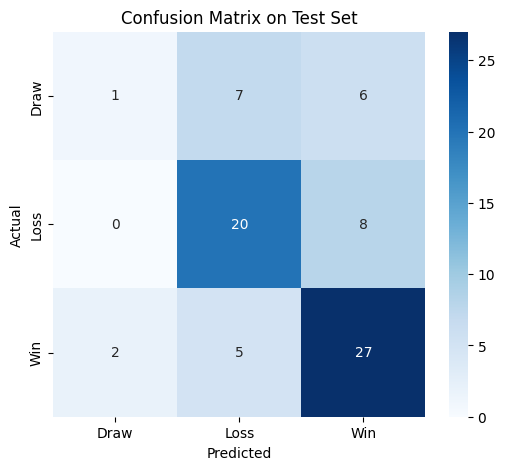

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_test_true_labels, y_test_pred_labels, labels=outcome_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=outcome_encoder.classes_,
            yticklabels=outcome_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

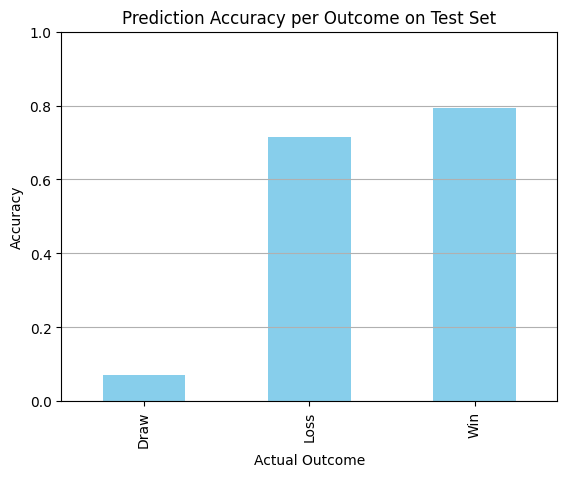

In [22]:
# Group by Actual Outcome and calculate mean accuracy
outcome_accuracy = test_results_df.groupby('Actual Outcome')['Correct'].mean()

# Plot
outcome_accuracy.plot(kind='bar', color='skyblue')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy per Outcome on Test Set')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

In [23]:
# Define low confidence threshold
low_confidence_threshold = 0.6

# Create a column marking low-confidence wrong predictions
test_results_df['Low-Confidence Wrong'] = (
    (~test_results_df['Correct']) & (test_results_df['Confidence'] < low_confidence_threshold)
)

# Display only low-confidence wrong predictions
low_conf_wrong_preds = test_results_df[test_results_df['Low-Confidence Wrong']]

print(f"Low-Confidence Wrong Predictions: {len(low_conf_wrong_preds)} matches")
print(low_conf_wrong_preds[['Actual Outcome', 'Predicted Outcome', 'Confidence']])

Low-Confidence Wrong Predictions: 11 matches
   Actual Outcome Predicted Outcome  Confidence
0            Loss               Win    0.443379
13           Draw               Win    0.423953
14           Draw              Loss    0.556986
16           Loss               Win    0.418790
24            Win              Draw    0.502897
30            Win              Loss    0.434777
43           Draw              Loss    0.401796
54           Draw               Win    0.494517
56           Loss               Win    0.471725
62           Draw              Loss    0.484019
75           Loss               Win    0.532307


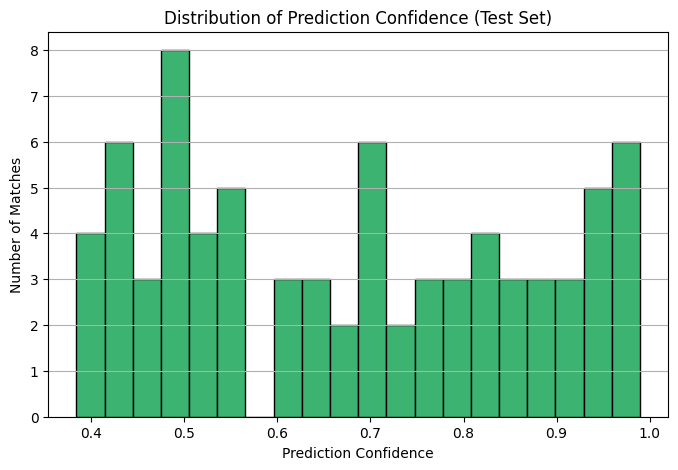

In [24]:
# Plot the distribution of confidence scores
plt.figure(figsize=(8,5))
plt.hist(test_results_df['Confidence'], bins=20, color='mediumseagreen', edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Number of Matches')
plt.title('Distribution of Prediction Confidence (Test Set)')
plt.grid(axis='y')
plt.show()

## Hyperparameter Tuning

Defining a Hypermodel

In [25]:
def build_model(hp):
    model = models.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(X_train.shape[1],)))
    
    # Tune number of hidden layers (1–3)
    for i in range(hp.Int('num_layers', 1, 3)):
        # Tune units per layer
        units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)
        model.add(layers.Dense(units, activation='relu'))
        
        # Tune dropout rate
        dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)
        model.add(layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(layers.Dense(3, activation='softmax'))  # 3 classes (Win, Draw, Loss)
    
    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Hyperparameter Search

In [26]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,  # How many different models to try
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_dir',
    project_name='soccer_match_outcome'
)

# Perform the search
tuner.search(
    X_train, y_train,
    epochs=30,
    validation_split=0.2,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 30 Complete [00h 00m 05s]
val_accuracy: 0.6557376980781555

Best val_accuracy So Far: 0.6721311211585999
Total elapsed time: 00h 05m 39s


Validation Accuracy Across Trials

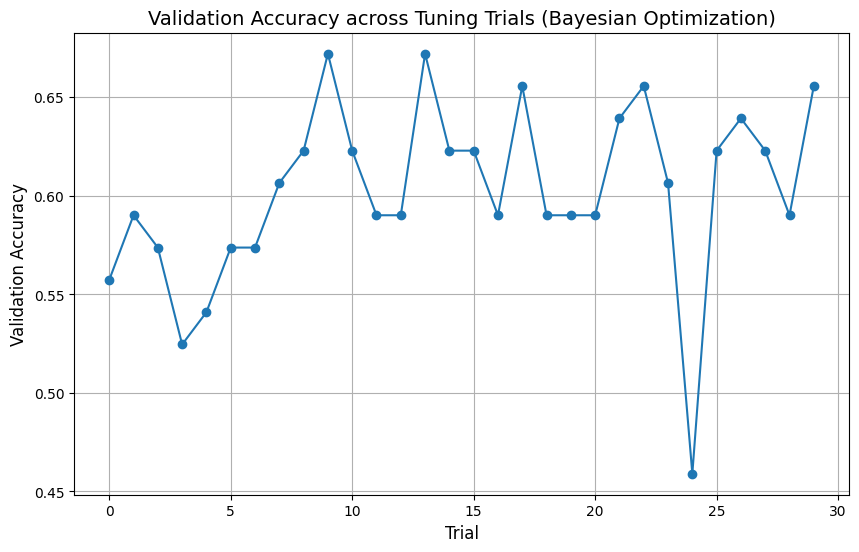

In [27]:
# Get all trials
trials = tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials))

# Extract validation metrics
trial_scores = []
for trial in trials:
    trial_id = trial.trial_id
    metrics_names = trial.metrics.metrics.keys()  # List available metrics

    if 'val_accuracy' in metrics_names:
        val_score = trial.metrics.get_last_value('val_accuracy')
        metric_used = 'Validation Accuracy'
    elif 'val_loss' in metrics_names:
        val_score = -trial.metrics.get_last_value('val_loss')  # Negative because lower loss = better
        metric_used = 'Negative Validation Loss'
    else:
        val_score = None  # Shouldn't happen unless tuning broke
        metric_used = 'Unknown'
    
    trial_scores.append((int(trial_id), val_score, metric_used))

# Build DataFrame
trials_df = pd.DataFrame(trial_scores, columns=['Trial', 'Score', 'Metric'])

# Sort by trial number
trials_df = trials_df.sort_values('Trial')

# Plot
plt.figure(figsize=(10,6))
plt.plot(trials_df['Trial'], trials_df['Score'], marker='o')
plt.title('Validation Accuracy across Tuning Trials (Bayesian Optimization)', fontsize=14)
plt.xlabel('Trial', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.grid(True)
plt.show()


By tuning hyperparameters accuracy was able to improve 15% from ~55% to ~70%. Let's try and use Bayesian Optimization to see if a better model can be found

Defining a New Hypermodel

In [34]:
def build_model(hp):
    model = models.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(X_train.shape[1],)))  # Adjust if you have team embeddings added

    # Hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(
            layers.Dense(
                units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=32),
                activation='relu'
            )
        )
        model.add(
            layers.Dropout(
                rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)
            )
        )

    # Output layer
    model.add(layers.Dense(3, activation='softmax'))

    # Optimizer
    optimizer = optimizers.Adam(
        learning_rate=hp.Float('learning_rate', 1e-4, 5e-3, sampling='log')
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

Hyperparamter Search

In [36]:
# 2. Instantiate Bayesian tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=30,           # More trials = better search, you can adjust
    executions_per_trial=1,  # Averaging can be added if you want even smoother results
    directory='tuner_dir',
    project_name='soccer_outcome_bayes'
)

# 3. Early stopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 4. Launch the tuning search
tuner.search(
    X_train, y_train,
    epochs=50,                     # Train longer so tuner sees real model potential
    validation_split=0.2,           # 20% validation
    callbacks=[early_stopping],
    verbose=2
)

# 5. Retrieve the best model
best_hp = tuner.get_best_hyperparameters(1)[0]

Trial 30 Complete [00h 00m 11s]
val_accuracy: 0.5901639461517334

Best val_accuracy So Far: 0.6393442749977112
Total elapsed time: 00h 05m 09s


## Training and Evaluating The Best Model Found

Predict and Evaluate

In [37]:
best_model = tuner.hypermodel.build(best_hp)
best_history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.4116 - loss: 1.4708 - val_accuracy: 0.4516 - val_loss: 1.2045
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5464 - loss: 1.0326 - val_accuracy: 0.5806 - val_loss: 0.9794
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5298 - loss: 0.9912 - val_accuracy: 0.4839 - val_loss: 1.0192
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5799 - loss: 0.9376 - val_accuracy: 0.4194 - val_loss: 1.0390
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6081 - loss: 0.8250 - val_accuracy: 0.3871 - val_loss: 1.0887
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6340 - loss: 0.7923 - val_accuracy: 0.4516 - val_loss: 1.1444
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5895 - loss: 0.8819 - val_accuracy: 0.3871 - val_loss: 1.0697
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6501 - loss: 0.7844 - val_accuracy: 0.3871 - val_loss: 1.1036


Predictions using the Best Model

In [39]:
# Predict probabilities on the test set
y_best_test_probs = best_model.predict(X_test)

# Predicted class labels (Win, Draw, Loss)
y_best_test_pred = np.argmax(y_best_test_probs, axis=1)

# True class labels (converted back from one-hot encoding)
y_best_test_true = np.argmax(y_test, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating the Best Model

In [40]:
print("Accuracy:", accuracy_score(y_best_test_true, y_best_test_pred))
print("Classification Report:\n", classification_report(y_best_test_true, y_best_test_pred, target_names=outcome_encoder.classes_))

Accuracy: 0.42105263157894735
Classification Report:
               precision    recall  f1-score   support

        Draw       0.31      0.29      0.30        14
        Loss       0.43      0.46      0.45        28
         Win       0.45      0.44      0.45        34

    accuracy                           0.42        76
   macro avg       0.40      0.40      0.40        76
weighted avg       0.42      0.42      0.42        76



In [51]:
y_best_test_pred_labels = outcome_encoder.inverse_transform(y_best_test_pred)
y_best_test_true_labels = outcome_encoder.inverse_transform(y_best_test_true)
# Build a dataframe to compare actual vs predicted
best_test_results_df = pd.DataFrame({
    'Actual Outcome': y_best_test_true_labels,
    'Predicted Outcome': y_best_test_pred_labels,
    'Confidence': np.max(y_best_test_probs, axis=1),
    'Win Prob': y_best_test_probs[:, outcome_encoder.transform(['Win'])[0]],
    'Draw Prob': y_best_test_probs[:, outcome_encoder.transform(['Draw'])[0]],
    'Loss Prob': y_best_test_probs[:, outcome_encoder.transform(['Loss'])[0]]
})


best_test_results_df['home_team_id']  = X_test['home_team_id'].values
best_test_results_df['away_team_id']  = X_test['away_team_id'].values

# Add 'Correct' column (True if prediction matches actual)
best_test_results_df['Correct'] = (best_test_results_df['Actual Outcome'] == best_test_results_df['Predicted Outcome'])

best_test_results_df['home_team_id']  = X_test['home_team_id'].values
best_test_results_df['away_team_id']  = X_test['away_team_id'].values

# Show the first few predictions
print(best_test_results_df.head())
best_test_results_df.to_csv('best_test_results_1.csv', index=False)

  Actual Outcome Predicted Outcome  Confidence  Win Prob  Draw Prob  \
0           Loss              Loss    0.878308  0.110255   0.011437   
1           Loss               Win    0.878059  0.878059   0.040306   
2            Win               Win    0.983912  0.983912   0.000266   
3           Draw              Draw    0.802091  0.192656   0.802091   
4            Win               Win    0.533841  0.533841   0.000147   

   Loss Prob  home_team_id  away_team_id  Correct  
0   0.878308             9            14     True  
1   0.081635            19            18    False  
2   0.015822             8             5     True  
3   0.005254             1             3     True  
4   0.466012            11             2     True  


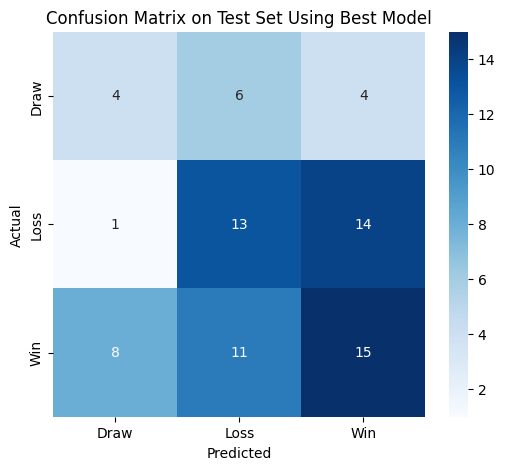

In [42]:
best_cm = confusion_matrix(y_best_test_true_labels, y_best_test_pred_labels, labels=outcome_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=outcome_encoder.classes_,
            yticklabels=outcome_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set Using Best Model')
plt.show()

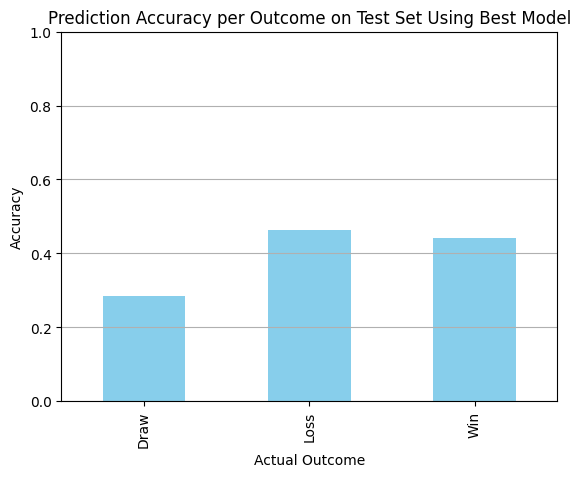

In [52]:
# Group by Actual Outcome and calculate mean accuracy
best_outcome_accuracy = best_test_results_df.groupby('Actual Outcome')['Correct'].mean()

# Plot
best_outcome_accuracy.plot(kind='bar', color='skyblue')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy per Outcome on Test Set Using Best Model')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()